In [1]:
#Importing Packages

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random

In [2]:
#Defining Necessary Functions

def P_vanishing(n,alpha,beta):
  return sp.special.jacobi(n,alpha,beta)-sp.special.jacobi(n,alpha,beta)(-1)

def P_doublevanishing(n,alpha,beta):
  return P_vanishing(n,alpha,beta)-((P_vanishing(n,alpha,beta)(1))/(P_vanishing(1,alpha,beta)(1)))*P_vanishing(1,alpha,beta)

def Tdv(alpha, beta, n_max):
  matrix = np.zeros((n_max-1,n_max-1))
  def integral(m,n):
    return np.polyint(P_doublevanishing(m+2, alpha, beta)*(-0.5*np.poly1d.deriv(np.poly1d.deriv(P_doublevanishing(n+2,alpha,beta)))))
  for n in range(0,n_max-1):
    for m in range(0,n_max-1):
      matrix[m][n] = integral(m,n)(1)-integral(m,n)(-1)
  return matrix

def Sdv(alpha, beta, n_max):
  matrix = np.zeros((n_max-1,n_max-1))
  def integral(m,n):
    return np.polyint(P_doublevanishing(m+2, alpha, beta)*P_doublevanishing(n+2,alpha,beta))
  for n in range(0,n_max-1):
    for m in range(0,n_max-1):
      matrix[m][n] = integral(m,n)(1)-integral(m,n)(-1)
  return matrix

def mix_density(old_density, new_density, mixing_parameter):
    return (1 - mixing_parameter) * old_density + mixing_parameter * new_density

def V_ext(v,x_0,sigma,n_max,alpha,beta,N):
  matrix = np.zeros((n_max-1,n_max-1))
  x = np.linspace(-1,1,N)
  for n in range(0,n_max-1):
    for m in range(0,n_max-1):
      matrix[m][n] = sp.integrate.simpson(P_doublevanishing(m+2,alpha,beta)(x)*P_doublevanishing(n+2,alpha,beta)(x)*sum(v[k]*np.exp(-((x_0[k]-x)**2)/(2*sigma[k]**2)) for k in range(0,len(v))),x = x)
  return matrix

def density_matrix(eigvecs,n_max,num_electrons):
    matrix = np.zeros((n_max-1,n_max-1))
    for n in range(n_max-1):
        for m in range(n_max-1):
            matrix[n][m] = sum(eigvecs[m,i]*eigvecs[n,i] for i in range(num_electrons))
    return matrix

In [9]:
def main(v,x_0,sigma,n_max,alpha,beta,N,max_scf_steps,num_electrons,U,density_tolerance,mixing_parameter):
    T = Tdv(alpha,beta,n_max)
    V = V_ext(v,x_0,sigma,n_max,alpha,beta,N)
    S = Sdv(alpha,beta,n_max)
    eigenValues, eigenVectors = sp.linalg.eig(T + V, S)
    idx = eigenValues.argsort()[::1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    for i in range(n_max-1):
        eigenVectors[:, i] = eigenVectors[:, i]/np.sqrt(np.dot(np.matmul(eigenVectors[:, i], S), eigenVectors[:, i]))
    noxc_density = np.poly1d([])
    for i in range(num_electrons):
        eigenvec = np.poly1d([])
        for n in range(0,n_max-1):
            eigenvec += (eigenVectors[:,i][n])*P_doublevanishing(n+2,alpha,beta)
        noxc_density += eigenvec**2
    t = np.linspace(-1, 1, 1001)
    data1 = sum(v[k]*np.exp(-((x_0[k]-t)**2)/(2*sigma[k]**2)) for k in range(0,len(v)))
    data2 = noxc_density(t)
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('$V_{ext}(x)$', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel('Density', color=color)  
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.title(f'Density plot of {num_electrons} electrons for no $V_{{xc}}$')
    plt.show()
    density = np.poly1d([num_electrons/2])
    plt.plot(np.linspace(-1,1,1001),density(np.linspace(-1,1,1001)))
    plt.title(f'Starting density with {num_electrons} electrons')
    plt.show()
    E_list = []
    E2_list = []
    T_list = []
    Vext_list = []
    Vxc_list = []
    Vh_list = []
    for scf_step in range(max_scf_steps):
        # Calculate XC potential and matrix
        def v_xc(x, density, U):
            return U*density(x)
        def V_xc(n_max,alpha,beta,N,U,density):
            matrix = np.zeros((n_max-1,n_max-1))
            x = np.linspace(-1,1,N)
            for n in range(0,n_max-1):
                for m in range(0,n_max-1):
                    matrix[m][n] = sp.integrate.simpson(P_doublevanishing(m+2,alpha,beta)(x)*P_doublevanishing(n+2,alpha,beta)(x)*v_xc(x,density,U),x = x)
            return matrix
        Vxc = V_xc(n_max,alpha,beta,N,U,density)

        x = np.linspace(-1,1,N)
        density_array = density(x)

        max_list = sp.signal.find_peaks((density_array))[0]
        min_list = sp.signal.find_peaks(-(density_array))[0]
        min_list = np.insert(min_list,0,0,axis = 0)
        min_list = np.insert(min_list,len(min_list),len(x),axis = 0)

        opposite = 0
        for i in range(len(max_list)):
            opposite -= sp.integrate.simpson(density_array[min_list[i]:min_list[i+1]], x = x[min_list[i]:min_list[i+1]])/(0.01*np.sqrt(2*np.pi))*np.exp(-(x-x[max_list[i]])**2/0.0002)
        temp_density = density_array + opposite

        def gauss_seidel_relaxation(v, neg_rho, h, num_iterations=3):
            """
            Perform Gauss-Seidel relaxation.
            
            Parameters:
            v: array, current solution
            neg_rho: array, right-hand side of Poisson equation (-n(x) in our case)
            h: float, grid spacing
            num_iterations: int, number of relaxation sweeps
            
            Returns:
            v: array, updated solution
            """
            
            for _ in range(num_iterations):
                for i in range(1, len(v) - 1):
                    v[i] = 0.5 * (v[i-1] + v[i+1] - h**2 * neg_rho[i])

                    
            return v

        def restrict(fine_grid):
            """
            Restrict from fine grid to coarse grid.
            """
            return fine_grid[::2]

        def prolong(coarse_grid):
            """
            Prolong from coarse grid to fine grid.
            """
            fine_grid = np.zeros(2*len(coarse_grid))
            fine_grid[::2] = coarse_grid
            fine_grid[1:-1:2] = 0.5 * (coarse_grid[:-1] + coarse_grid[1:])
            return fine_grid

        def v_cycle(v, neg_rho, h, level, max_level):
            """
            Perform one V-cycle of the multigrid method.
            
            Parameters:
            v: array, current solution
            neg_rho: array, right-hand side of Poisson equation
            h: float, grid spacing
            level: int, current grid level
            max_level: int, maximum number of grid levels
            
            Returns:
            v: array, updated solution
            """
            # Pre-smoothing
            v = gauss_seidel_relaxation(v, temp_density, h)

            
            if level < max_level:
                # Compute residual
                def ddv(v, h, neg_rho):
                    vnew = np.array([(v[i+1]+v[i-1]-2*v[i])/(h**2) for i in range(1,len(v)-1)])
                    vnew = np.insert(vnew,0,neg_rho[0],axis = 0)
                    vnew = np.insert(vnew,len(vnew),neg_rho[len(vnew)],axis = 0)
                    return vnew
                
                r = neg_rho - ddv(v,h,neg_rho)
                
                # Restrict residual to coarser grid
                r_c = restrict(r)
                
                # Recursive call on coarser grid
                e_c = np.zeros_like(r_c)
                e_c = v_cycle(e_c, r_c, 2*h, level+1, max_level)
                
                
                # Prolong error and correct solution
                e = prolong(e_c)
                v += e

            else:
                # Solve exactly on coarsest grid
                v = gauss_seidel_relaxation(v, neg_rho, h, num_iterations=100)
            
            # Post-smoothing
            v = gauss_seidel_relaxation(v, neg_rho, h)
            
            return v

        def poisson_solver(density, x, tolerance=1e-8, num_v_cycles=4000, max_level=7):
            """
            Solve Poisson equation using multigrid method.
            
            Parameters:
            density: array, electron density
            x: array, spatial grid
            num_v_cycles: int, number of V-cycles to perform
            max_level: int, maximum number of grid levels
            
            Returns:
            v_H: array, Hartree potential
            """
            h = x[1] - x[0]
            neg_rho = -density
            # Right-hand side of Poisson equation
            
            # Initial guess for v_H
            v_H = np.zeros_like(x)
            
            # Perform V-cycles
            for i in range(num_v_cycles):
                v_H_old = v_H.copy()
                v_H = v_cycle(v_H, neg_rho, h, 0, max_level)
                if np.max(np.abs(v_H - v_H_old)) < tolerance:
                    print(f'Converged after {i+1} v cycles')
                    print(f'Minimum of potential = {min(v_H)}')
                    break
            
            # Ensure v_H = 0 at boundaries   (Dirichlet boundary conditions)
            v_H -= v_H[0]
            
            return v_H
        
        vh = poisson_solver(temp_density, x)
        def V_H(n_max,alpha,beta,N,vh):
            matrix = np.zeros((n_max-1,n_max-1))
            x = np.linspace(-1,1,N)
            for n in range(0,n_max-1):
                for m in range(0,n_max-1):
                    matrix[m][n] = sp.integrate.simpson(P_doublevanishing(m+2,alpha,beta)(x)*P_doublevanishing(n+2,alpha,beta)(x)*vh,x = x)
            return matrix

        Vh = V_H(n_max,alpha,beta,N,vh) 
        H = T + V + Vxc + Vh
        # Construct Hamiltonian

        
        # Solve generalized eigenvalue problem
        eigenValues, eigenVectors = sp.linalg.eig(H, S)
        idx = eigenValues.argsort()[::1]
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:, idx]
        for i in range(n_max-1):
            eigenVectors[:, i] = eigenVectors[:, i]/np.sqrt(np.dot(np.matmul(eigenVectors[:, i], S), eigenVectors[:, i]))
        new_density = np.poly1d([])
        for i in range(num_electrons):
            eigenvec = np.poly1d([])
            for n in range(0,n_max-1):
                eigenvec += (eigenVectors[:,i][n])*P_doublevanishing(n+2,alpha,beta)
            new_density += eigenvec**2
        
        print(f'Energy of system calculated using eigenvalues = {sum([eigenValues[n] for n in range(num_electrons)]).real}')
        E_list.append(sum([eigenValues[n] for n in range(num_electrons)]).real)

        print(f'Energy of system calculated using density matrix = {np.trace(np.matmul(H,density_matrix(eigenVectors,n_max,num_electrons)))}')
        E2_list.append(np.trace(np.matmul(H,density_matrix(eigenVectors,n_max,num_electrons))))

        T_list.append(np.trace(np.matmul(T,density_matrix(eigenVectors,n_max,num_electrons))))
        Vext_list.append(np.trace(np.matmul(V,density_matrix(eigenVectors,n_max,num_electrons))))
        Vxc_list.append(np.trace(np.matmul(Vxc,density_matrix(eigenVectors,n_max,num_electrons))))
        Vh_list.append(np.trace(np.matmul(Vh,density_matrix(eigenVectors,n_max,num_electrons))))

        t = np.linspace(-1, 1, N)
        data1 = sum(v[k]*np.exp(-((x_0[k]-t)**2)/(2*sigma[k]**2)) for k in range(0,len(v)))
        data2 = new_density(t)

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Position (x)')
        ax1.set_ylabel('$V_{ext}(x)$', color=color)
        ax1.plot(t, data1, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  

        color = 'tab:blue'
        ax2.set_ylabel('Density', color=color)  
        ax2.plot(t, data2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  
        plt.title(f'Density plot of {num_electrons} electrons for {scf_step + 1} steps')
        plt.show()
        
        # Check for convergence
        if np.allclose(new_density(t), density(t), atol=density_tolerance):
            print(f"SCF converged after {scf_step + 1} steps")
            break
        
        # Mix densities
        density = mix_density(density, new_density, mixing_parameter)


    plt.plot(x, density(x),label = 'Density')
    plt.plot(x, vh, label = 'Hartree Potential')
    plt.title(f'Density Plot of {num_electrons} for U = {U}')
    plt.xlabel('Position (x)')
    plt.ylabel('Electron Density/Potential Energy')
    plt.legend()
    plt.show()
    plt.scatter(np.arange(1,len(E_list)+1),E_list, label = 'Eigenvalues')
    plt.scatter(np.arange(1,len(E2_list)+1),E2_list, label = 'Density Matrix Values')
    plt.title('Plot of the energy of the system')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()
    plt.scatter(np.arange(1,len(T_list)+1),T_list)
    plt.title('Plot of the kinetic energy of the system')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.show()
    plt.scatter(np.arange(1,len(Vext_list)+1),Vext_list)
    plt.title('Plot of the external energy of the system')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.show()
    plt.scatter(np.arange(1,len(Vxc_list)+1),Vxc_list)
    plt.title('Plot of the exchange correlation energy of the system')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.show()
    plt.scatter(np.arange(1,len(Vh_list)+1),Vh_list)
    plt.title('Plot of the Hartree potential energy of the system')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.show()

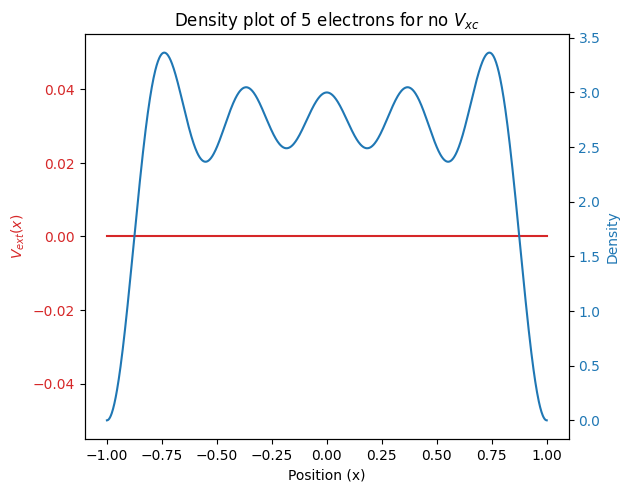

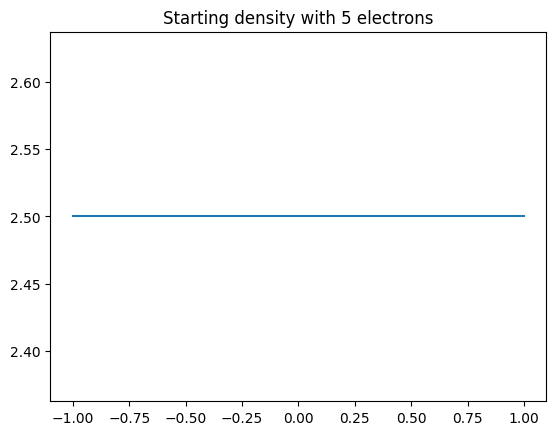

Converged after 58 v cycles
Minimum of potential = 0.0
Energy of system calculated using eigenvalues = 197.2005952649094
Energy of system calculated using density matrix = 197.20059526490928


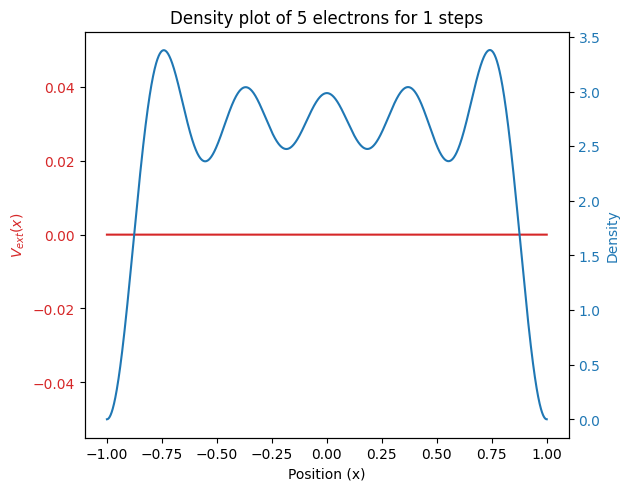

Converged after 57 v cycles
Minimum of potential = -0.2468474746396718
Energy of system calculated using eigenvalues = 202.5035662315989
Energy of system calculated using density matrix = 202.50356623159934


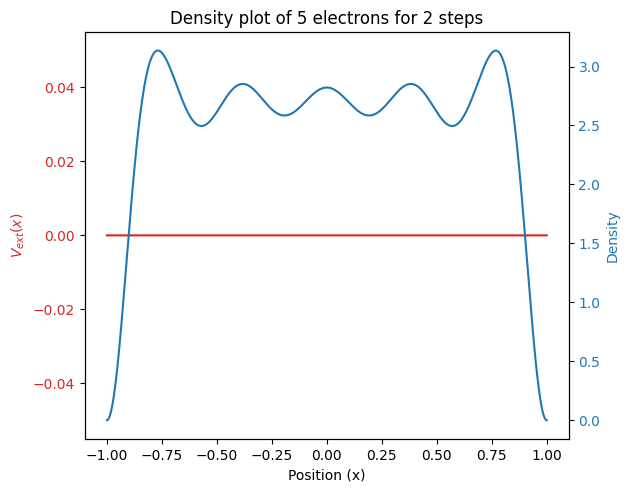

Converged after 57 v cycles
Minimum of potential = -0.22099791520029816
Energy of system calculated using eigenvalues = 202.5022578574662
Energy of system calculated using density matrix = 202.5022578574665


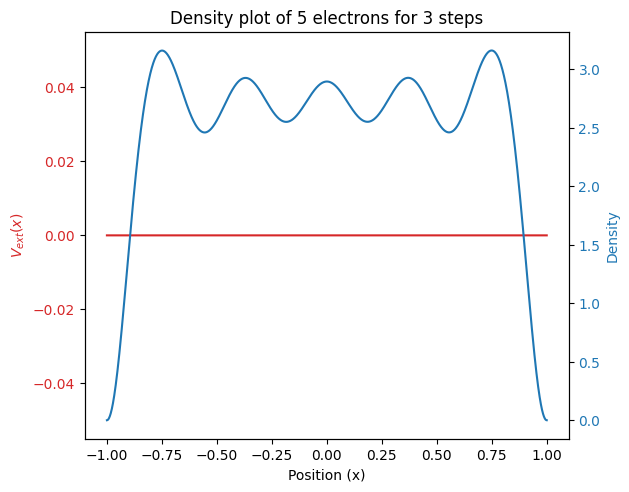

Converged after 58 v cycles
Minimum of potential = -0.43338122139394825
Energy of system calculated using eigenvalues = 202.0009475189613
Energy of system calculated using density matrix = 202.00094751896177


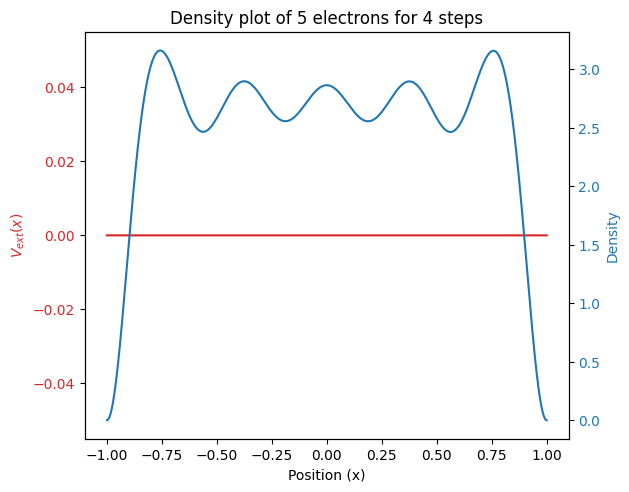

Converged after 58 v cycles
Minimum of potential = -0.4128372101357095
Energy of system calculated using eigenvalues = 202.0076151587477
Energy of system calculated using density matrix = 202.0076151587478


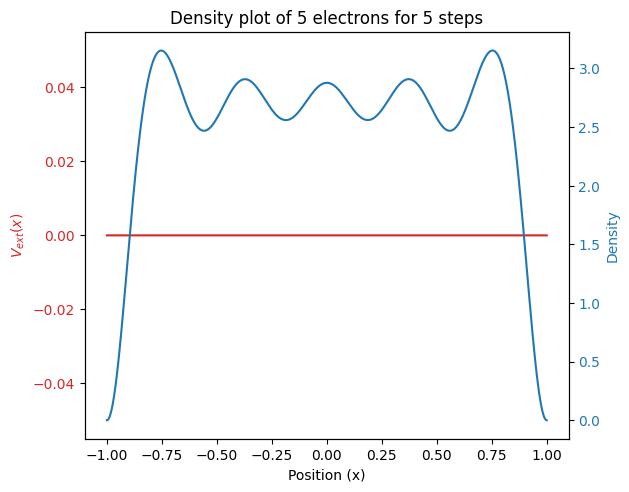

Converged after 58 v cycles
Minimum of potential = -0.4467446196968292
Energy of system calculated using eigenvalues = 201.9164126260873
Energy of system calculated using density matrix = 201.9164126260874


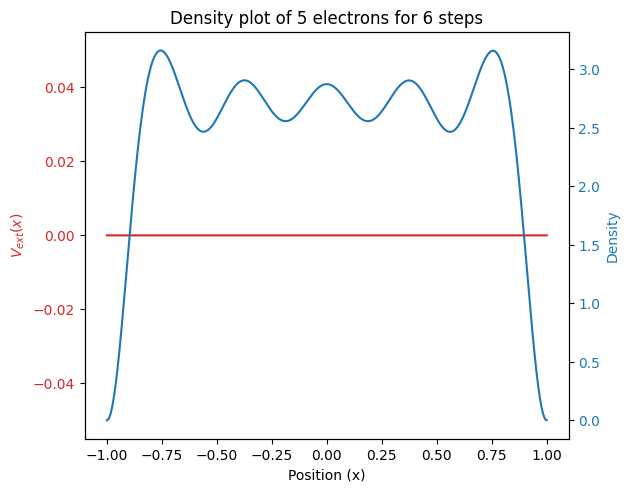

Converged after 58 v cycles
Minimum of potential = -0.42946744606847004
Energy of system calculated using eigenvalues = 201.96817353305622
Energy of system calculated using density matrix = 201.96817353305659


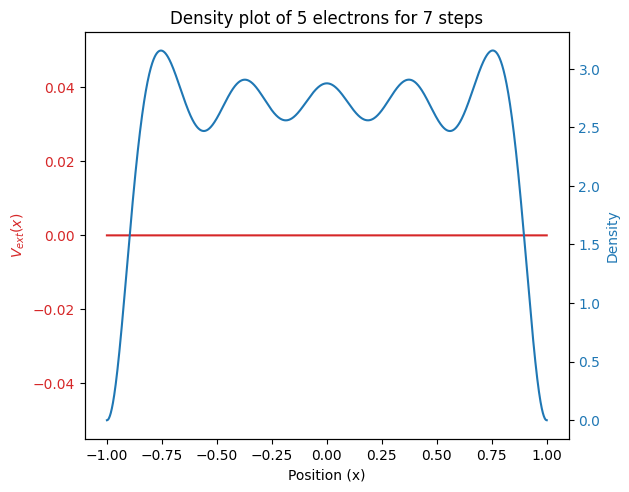

Converged after 58 v cycles
Minimum of potential = -0.4311113728209733
Energy of system calculated using eigenvalues = 201.96771363158845
Energy of system calculated using density matrix = 201.96771363158862


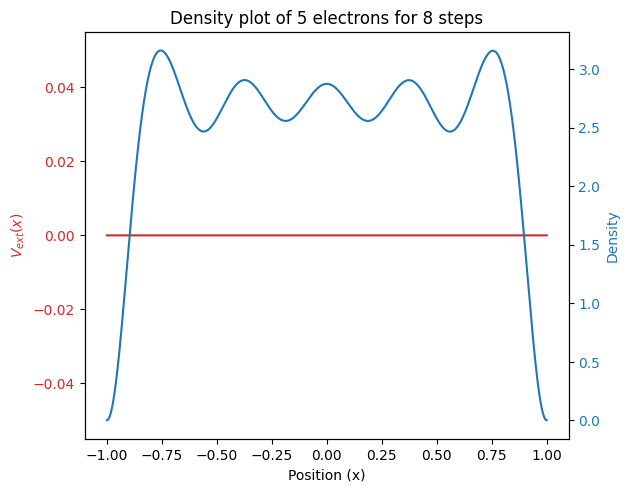

SCF converged after 8 steps


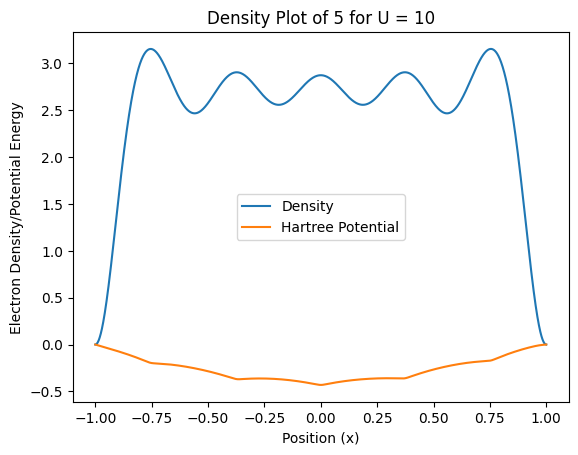

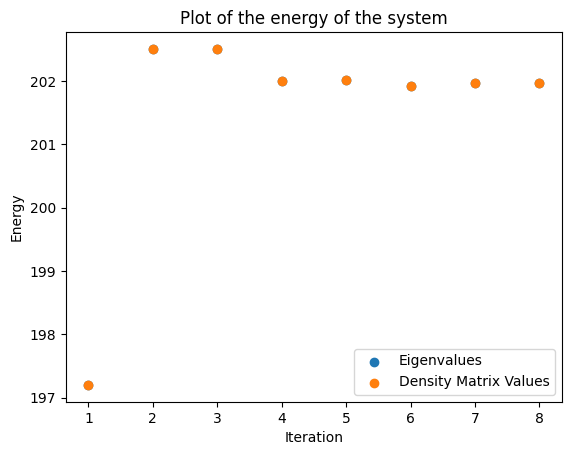

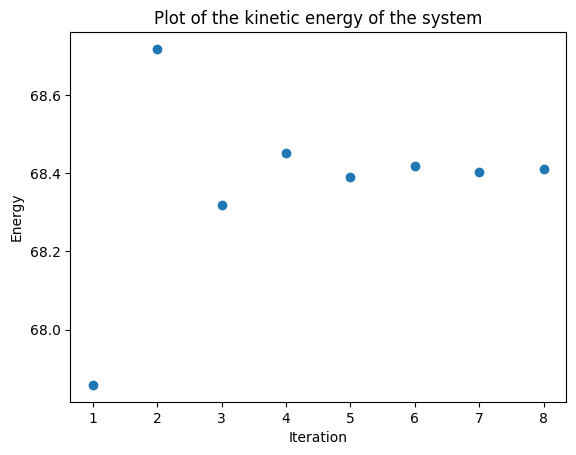

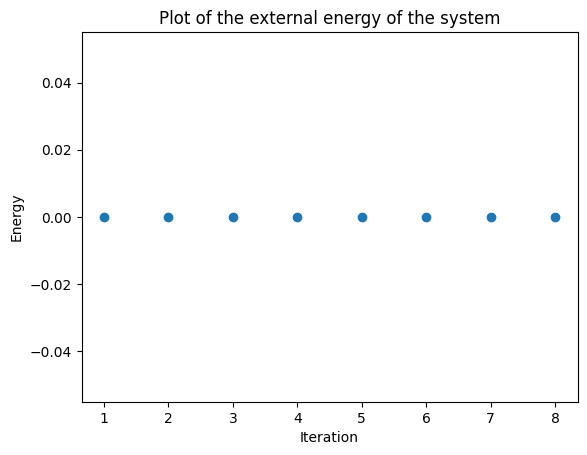

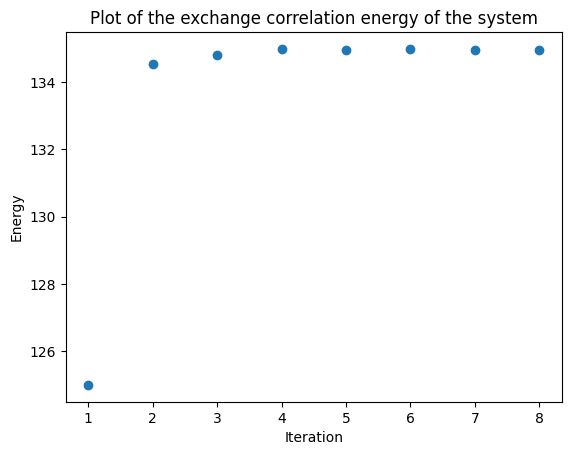

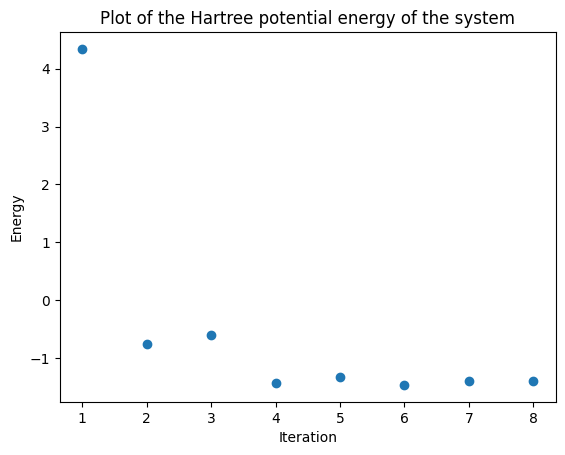

In [10]:
main(v=[0],x_0=[0],sigma=[0.1],n_max=20,alpha=0,beta=0,N=int(2**11),max_scf_steps=100,num_electrons=5,U=10,density_tolerance=0.01,mixing_parameter=0.9)

In [11]:
def U_plotter(v,x_0,sigma,n_max,alpha,beta,N,max_scf_steps,num_electrons,U_list,density_tolerance,mixing_parameter):
    T = Tdv(alpha,beta,n_max)
    V = V_ext(v,x_0,sigma,n_max,alpha,beta,N)
    S = Sdv(alpha,beta,n_max)
    eigenValues, eigenVectors = sp.linalg.eig(T + V, S)
    idx = eigenValues.argsort()[::1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    for i in range(n_max-1):
        eigenVectors[:, i] = eigenVectors[:, i]/np.sqrt(np.dot(np.matmul(eigenVectors[:, i], S), eigenVectors[:, i]))
    noxc_density = np.poly1d([])
    for i in range(num_electrons):
        eigenvec = np.poly1d([])
        for n in range(0,n_max-1):
            eigenvec += (eigenVectors[:,i][n])*P_doublevanishing(n+2,alpha,beta)
        noxc_density += eigenvec**2
    t = np.linspace(-1, 1, 1001)
    data1 = sum(v[k]*np.exp(-((x_0[k]-t)**2)/(2*sigma[k]**2)) for k in range(0,len(v)))
    data2 = noxc_density(t)
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('$V_{ext}(x)$', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel('Density', color=color)  
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.title(f'Density plot of {num_electrons} electrons for no $V_{{xc}}$')
    plt.show()

    density = np.poly1d([num_electrons/2])
    plt.plot(np.linspace(-1,1,1001),density(np.linspace(-1,1,1001)))
    plt.title(f'Starting density with {num_electrons} electrons')
    plt.show()

    E_list = []
    T_list = []
    Vext_list = []
    Vxc_list = []
    Vh_list = []

    for u in U_list:
        for scf_step in range(max_scf_steps):
            # Calculate XC potential and matrix
            def v_xc(x, density, U):
                return U*density(x)
            def V_xc(n_max,alpha,beta,N,U,density):
                matrix = np.zeros((n_max-1,n_max-1))
                x = np.linspace(-1,1,N)
                for n in range(0,n_max-1):
                    for m in range(0,n_max-1):
                        matrix[m][n] = sp.integrate.simpson(P_doublevanishing(m+2,alpha,beta)(x)*P_doublevanishing(n+2,alpha,beta)(x)*v_xc(x,density,U),x = x)
                return matrix
            
            # Construct Hamiltonian
            Vxc = V_xc(n_max,alpha,beta,N,u,density)
            x = np.linspace(-1,1,N)
            density_array = density(x)

            max_list = sp.signal.find_peaks((density_array))[0]
            min_list = sp.signal.find_peaks(-(density_array))[0]
            min_list = np.insert(min_list,0,0,axis = 0)
            min_list = np.insert(min_list,len(min_list),len(x),axis = 0)

            opposite = 0
            for i in range(len(max_list)):
                opposite -= sp.integrate.simpson(density_array[min_list[i]:min_list[i+1]], x = x[min_list[i]:min_list[i+1]])/(0.01*np.sqrt(2*np.pi))*np.exp(-(x-x[max_list[i]])**2/0.0002)
            temp_density = density_array + opposite

            def gauss_seidel_relaxation(v, neg_rho, h, num_iterations=3):
                """
                Perform Gauss-Seidel relaxation.
                
                Parameters:
                v: array, current solution
                neg_rho: array, right-hand side of Poisson equation (-n(x) in our case)
                h: float, grid spacing
                num_iterations: int, number of relaxation sweeps
                
                Returns:
                v: array, updated solution
                """
                
                for _ in range(num_iterations):
                    for i in range(1, len(v) - 1):
                        v[i] = 0.5 * (v[i-1] + v[i+1] - h**2 * neg_rho[i])

                        
                return v

            def restrict(fine_grid):
                """
                Restrict from fine grid to coarse grid.
                """
                return fine_grid[::2]

            def prolong(coarse_grid):
                """
                Prolong from coarse grid to fine grid.
                """
                fine_grid = np.zeros(2*len(coarse_grid))
                fine_grid[::2] = coarse_grid
                fine_grid[1:-1:2] = 0.5 * (coarse_grid[:-1] + coarse_grid[1:])
                return fine_grid

            def v_cycle(v, neg_rho, h, level, max_level):
                """
                Perform one V-cycle of the multigrid method.
                
                Parameters:
                v: array, current solution
                neg_rho: array, right-hand side of Poisson equation
                h: float, grid spacing
                level: int, current grid level
                max_level: int, maximum number of grid levels
                
                Returns:
                v: array, updated solution
                """
                # Pre-smoothing
                v = gauss_seidel_relaxation(v, temp_density, h)

                
                if level < max_level:
                    # Compute residual
                    def ddv(v, h, neg_rho):
                        vnew = np.array([(v[i+1]+v[i-1]-2*v[i])/(h**2) for i in range(1,len(v)-1)])
                        vnew = np.insert(vnew,0,neg_rho[0],axis = 0)
                        vnew = np.insert(vnew,len(vnew),neg_rho[len(vnew)],axis = 0)
                        return vnew
                    
                    r = neg_rho - ddv(v,h,neg_rho)
                    
                    # Restrict residual to coarser grid
                    r_c = restrict(r)
                    
                    # Recursive call on coarser grid
                    e_c = np.zeros_like(r_c)
                    e_c = v_cycle(e_c, r_c, 2*h, level+1, max_level)
                    
                    
                    # Prolong error and correct solution
                    e = prolong(e_c)
                    v += e

                else:
                    # Solve exactly on coarsest grid
                    v = gauss_seidel_relaxation(v, neg_rho, h, num_iterations=100)
                
                # Post-smoothing
                v = gauss_seidel_relaxation(v, neg_rho, h)
                
                return v

            def poisson_solver(density, x, tolerance=1e-8, num_v_cycles=4000, max_level=7):
                """
                Solve Poisson equation using multigrid method.
                
                Parameters:
                density: array, electron density
                x: array, spatial grid
                num_v_cycles: int, number of V-cycles to perform
                max_level: int, maximum number of grid levels
                
                Returns:
                v_H: array, Hartree potential
                """
                h = x[1] - x[0]
                neg_rho = -density
                # Right-hand side of Poisson equation
                
                # Initial guess for v_H
                v_H = np.zeros_like(x)
                
                # Perform V-cycles
                for i in range(num_v_cycles):
                    v_H_old = v_H.copy()
                    v_H = v_cycle(v_H, neg_rho, h, 0, max_level)
                    if np.max(np.abs(v_H - v_H_old)) < tolerance:
                        print(f'Converged after {i+1} v cycles')
                        print(f'Minimum of potential = {min(v_H)}')
                        break
                
                # Ensure v_H = 0 at boundaries   (Dirichlet boundary conditions)
                v_H -= v_H[0]
                
                return v_H
            vh = poisson_solver(temp_density, x)
            def V_H(n_max,alpha,beta,N,vh):
                matrix = np.zeros((n_max-1,n_max-1))
                x = np.linspace(-1,1,N)
                for n in range(0,n_max-1):
                    for m in range(0,n_max-1):
                        matrix[m][n] = sp.integrate.simpson(P_doublevanishing(m+2,alpha,beta)(x)*P_doublevanishing(n+2,alpha,beta)(x)*vh,x = x)
                return matrix
            Vh = V_H(n_max,alpha,beta,N,vh) 
            H = T + V + Vxc +Vh
            
            # Solve generalized eigenvalue problem
            eigenValues, eigenVectors = sp.linalg.eig(H, S)
            idx = eigenValues.argsort()[::1]
            eigenValues = eigenValues[idx]
            eigenVectors = eigenVectors[:, idx]
            for i in range(n_max-1):
                eigenVectors[:, i] = eigenVectors[:, i]/np.sqrt(np.dot(np.matmul(eigenVectors[:, i], S), eigenVectors[:, i]))

            new_density = np.poly1d([])
            for i in range(num_electrons):
                eigenvec = np.poly1d([])
                for n in range(0,n_max-1):
                    eigenvec += (eigenVectors[:,i][n])*P_doublevanishing(n+2,alpha,beta)
                new_density += eigenvec**2
            

            # Check for convergence
            if np.allclose(new_density(t), density(t), atol=density_tolerance):
                print(f"SCF converged after {scf_step + 1} steps for U = {u}")
                E_list.append(sum([eigenValues[n] for n in range(num_electrons)]).real)
                T_list.append(np.trace(np.matmul(T,density_matrix(eigenVectors,n_max,num_electrons))))
                Vext_list.append(np.trace(np.matmul(V,density_matrix(eigenVectors,n_max,num_electrons))))
                Vxc_list.append(np.trace(np.matmul(Vxc,density_matrix(eigenVectors,n_max,num_electrons))))
                Vh_list.append(np.trace(np.matmul(Vh,density_matrix(eigenVectors,n_max,num_electrons))))
                break
            
            # Mix densities
            density = mix_density(density, new_density, mixing_parameter)

        t = np.linspace(-1, 1, N)
        data1 = sum(v[k]*np.exp(-((x_0[k]-t)**2)/(2*sigma[k]**2)) for k in range(0,len(v)))
        data2 = new_density(t)
        new = sp.integrate.simpson(data2, x=t)
        print(f'Total no. of electrons = {new}')

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Position (x)')
        ax1.set_ylabel('$V_{ext}(x)$', color=color)
        ax1.plot(t, data1, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  

        color = 'tab:blue'
        ax2.set_ylabel('Density', color=color)  
        ax2.plot(t, data2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  
        plt.title(f'Density plot of {num_electrons} electrons for U = {u}')
        plt.show()
    
    print(f'Length of E list : {len(E_list)}')
    print(f'Length of U list : {len(U_list)}')

    plt.scatter(U_list,E_list)
    plt.title('Plot of the energy of the system for different U')
    plt.xlabel('Value of U coefficient')
    plt.ylabel('Energy')
    plt.show()
    plt.scatter(U_list,T_list)
    plt.title('Plot of the kinetic energy of the system for different U')
    plt.xlabel('Value of U coefficient')
    plt.ylabel('Kinetic Energy')
    plt.show()
    plt.scatter(U_list,Vext_list)
    plt.title('Plot of the external potential of the system for different U')
    plt.xlabel('Value of U coefficient')
    plt.ylabel('External Potential Energy')
    plt.show()
    plt.scatter(U_list,Vxc_list)
    plt.title('Plot of the exchange correlation of the system for different U')
    plt.xlabel('Value of U coefficient')
    plt.ylabel('Exchange Correlation Potential Energy')
    plt.show()
    plt.scatter(U_list,Vh_list)
    plt.title('Plot of the Hartree Potential of the system for different U')
    plt.xlabel('Value of U coefficient')
    plt.ylabel('Hartree Potential Energy')
    plt.show()

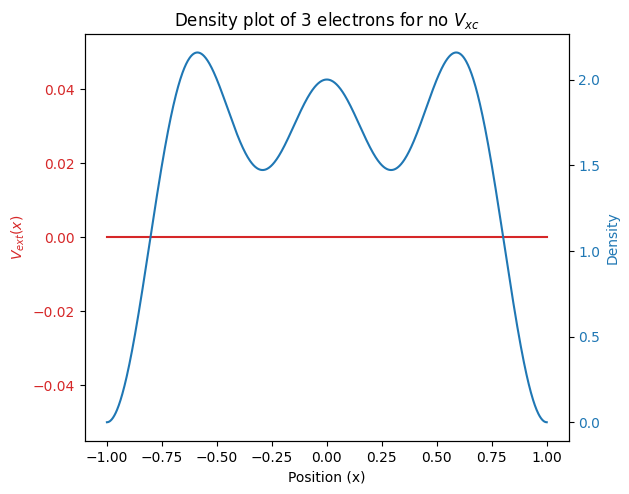

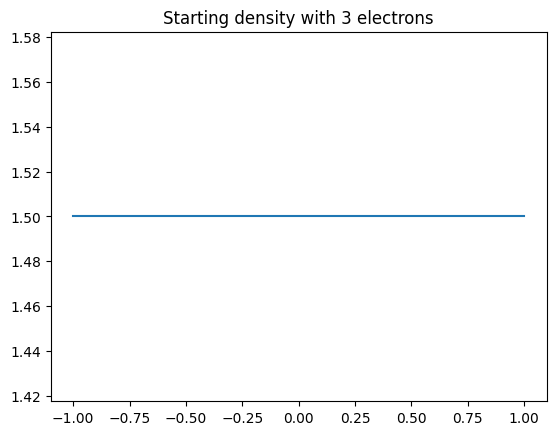

Converged after 56 v cycles
Minimum of potential = 0.0
Converged after 47 v cycles
Minimum of potential = -0.24372895782079196
Converged after 45 v cycles
Minimum of potential = -0.2283187936648269
Converged after 44 v cycles
Minimum of potential = -0.22234249142584414
Converged after 39 v cycles
Minimum of potential = -0.2125596856580301
Converged after 34 v cycles
Minimum of potential = -0.20755856450122132
Converged after 41 v cycles
Minimum of potential = -0.20306984060032568
Converged after 43 v cycles
Minimum of potential = -0.19904169954641363
Converged after 43 v cycles
Minimum of potential = -0.19954972749219899
Converged after 44 v cycles
Minimum of potential = -0.19629182163449596
Converged after 45 v cycles
Minimum of potential = -0.19336745920287923
Converged after 45 v cycles
Minimum of potential = -0.1907424699490532
Converged after 46 v cycles
Minimum of potential = -0.18838617317194845
Converged after 46 v cycles
Minimum of potential = -0.18627105017051943
Converged af

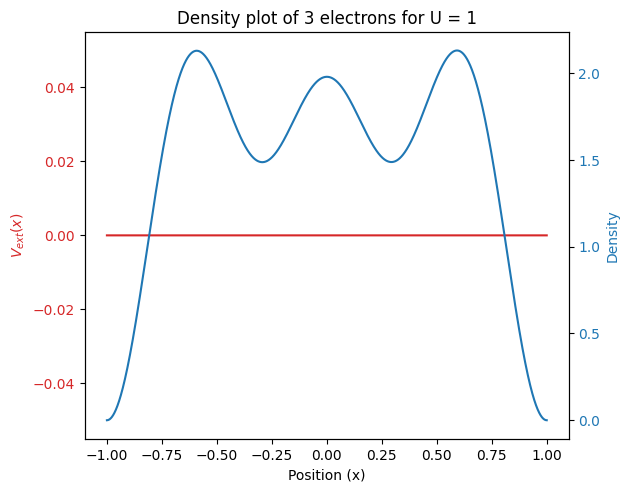

Converged after 48 v cycles
Minimum of potential = -0.1748017795835816
Converged after 48 v cycles
Minimum of potential = -0.17604224222094164
Converged after 48 v cycles
Minimum of potential = -0.17615663884525068
Converged after 48 v cycles
Minimum of potential = -0.17684988822886238
Converged after 48 v cycles
Minimum of potential = -0.17671862674298378
Converged after 48 v cycles
Minimum of potential = -0.17738299095825003
Converged after 48 v cycles
Minimum of potential = -0.1774527115335702
Converged after 48 v cycles
Minimum of potential = -0.17622553315650996
Converged after 48 v cycles
Minimum of potential = -0.17588426624626527
Converged after 48 v cycles
Minimum of potential = -0.17593220991328457
Converged after 48 v cycles
Minimum of potential = -0.1759744436085013
Converged after 48 v cycles
Minimum of potential = -0.17601164558550306
Converged after 48 v cycles
Minimum of potential = -0.1760444137285306
SCF converged after 13 steps for U = 2
Total no. of electrons = 2.99

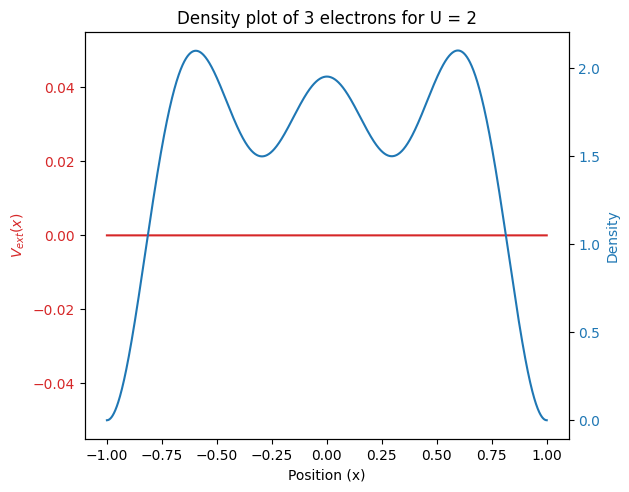

Converged after 48 v cycles
Minimum of potential = -0.1760444137285306
Converged after 49 v cycles
Minimum of potential = -0.173619913482985
Converged after 49 v cycles
Minimum of potential = -0.17379819156385498
Converged after 49 v cycles
Minimum of potential = -0.16975694269628067
Converged after 49 v cycles
Minimum of potential = -0.1698944329861853
Converged after 49 v cycles
Minimum of potential = -0.16369994364557816
Converged after 49 v cycles
Minimum of potential = -0.16380582744827044
Converged after 49 v cycles
Minimum of potential = -0.1638986190220902
Converged after 50 v cycles
Minimum of potential = -0.16217101850735882
Converged after 50 v cycles
Minimum of potential = -0.15693163386245415
Converged after 50 v cycles
Minimum of potential = -0.15699483884256263
Converged after 50 v cycles
Minimum of potential = -0.15766291342119615
Converged after 50 v cycles
Minimum of potential = -0.15771163870967622
Converged after 50 v cycles
Minimum of potential = -0.157754351822849

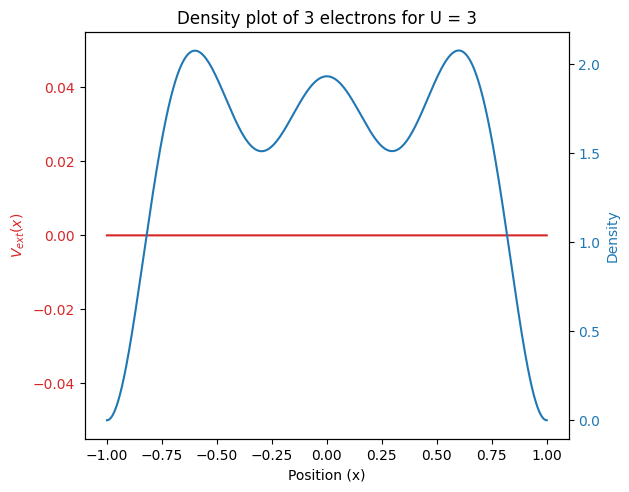

Converged after 50 v cycles
Minimum of potential = -0.15775435182284947
Converged after 50 v cycles
Minimum of potential = -0.1489966642762544
Converged after 51 v cycles
Minimum of potential = -0.1464148485578543
Converged after 51 v cycles
Minimum of potential = -0.13999564218074165
Converged after 51 v cycles
Minimum of potential = -0.1401307899471187
Converged after 51 v cycles
Minimum of potential = -0.13025580822966473
Converged after 51 v cycles
Minimum of potential = -0.1303583307460688
Converged after 51 v cycles
Minimum of potential = -0.1304474695368476
Converged after 52 v cycles
Minimum of potential = -0.1277319759660812
Converged after 52 v cycles
Minimum of potential = -0.11964980795096343
Converged after 52 v cycles
Minimum of potential = -0.11970877934405189
Converged after 52 v cycles
Minimum of potential = -0.11976006296000538
Converged after 52 v cycles
Minimum of potential = -0.11980466793129926
Converged after 52 v cycles
Minimum of potential = -0.1198434701189095

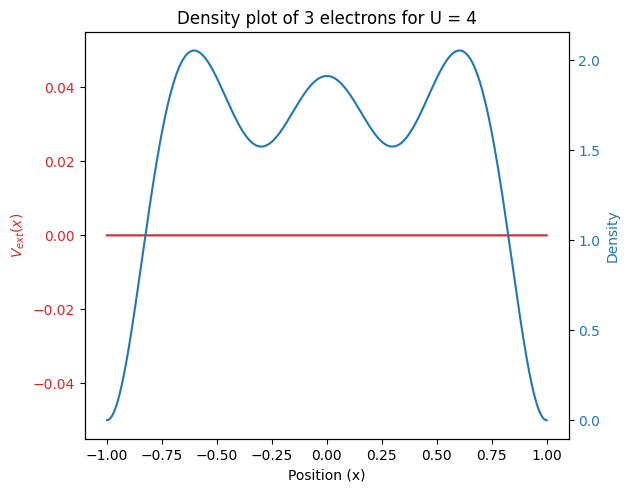

Converged after 52 v cycles
Minimum of potential = -0.1198434701189095
Converged after 52 v cycles
Minimum of potential = -0.11051190566158708
Converged after 52 v cycles
Minimum of potential = -0.10825057423436686
Converged after 53 v cycles
Minimum of potential = -0.10056540137355695
Converged after 53 v cycles
Minimum of potential = -0.10068831947793522
Converged after 53 v cycles
Minimum of potential = -0.09158838218692773
Converged after 53 v cycles
Minimum of potential = -0.09167953773053238
Converged after 53 v cycles
Minimum of potential = -0.091758133755473
Converged after 53 v cycles
Minimum of potential = -0.09317346504218776
Converged after 53 v cycles
Minimum of potential = -0.08557885478761268
Converged after 53 v cycles
Minimum of potential = -0.0863913302385632
Converged after 53 v cycles
Minimum of potential = -0.08643519560842988
Converged after 53 v cycles
Minimum of potential = -0.08647305679083063
SCF converged after 13 steps for U = 5
Total no. of electrons = 2.99

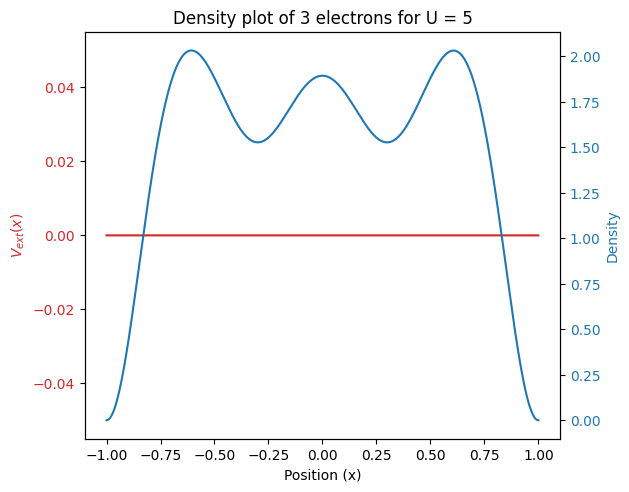

Converged after 53 v cycles
Minimum of potential = -0.08647305679083063
Converged after 54 v cycles
Minimum of potential = -0.08102069044348356
Converged after 54 v cycles
Minimum of potential = -0.08117675818355323
Converged after 54 v cycles
Minimum of potential = -0.07813442250896707
Converged after 54 v cycles
Minimum of potential = -0.0796275938912965
Converged after 54 v cycles
Minimum of potential = -0.07972556535940672
Converged after 54 v cycles
Minimum of potential = -0.0794796378953334
Converged after 54 v cycles
Minimum of potential = -0.07955138048425726
Converged after 54 v cycles
Minimum of potential = -0.07961277955911333
Converged after 54 v cycles
Minimum of potential = -0.07966534583291382
Converged after 54 v cycles
Minimum of potential = -0.07971036667499341
Converged after 54 v cycles
Minimum of potential = -0.08256310019642109
SCF converged after 12 steps for U = 6
Total no. of electrons = 2.9999999999355134


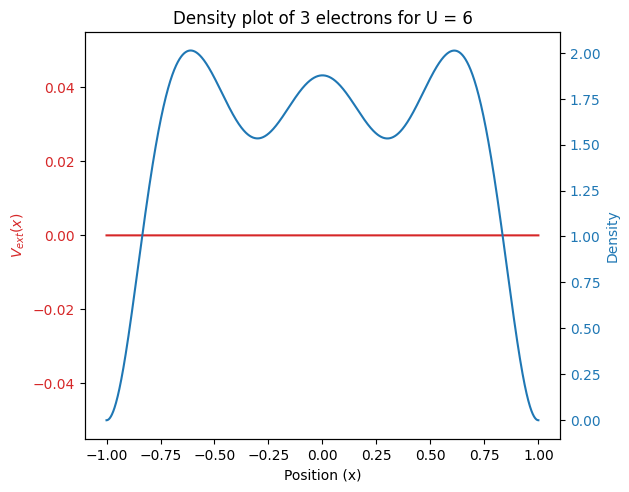

Converged after 54 v cycles
Minimum of potential = -0.08256310019642109
Converged after 54 v cycles
Minimum of potential = -0.08274324104374249
Converged after 55 v cycles
Minimum of potential = -0.09042277742621428
Converged after 55 v cycles
Minimum of potential = -0.0905532274936097
Converged after 55 v cycles
Minimum of potential = -0.1002185077571601
Converged after 55 v cycles
Minimum of potential = -0.10031254103395974
Converged after 55 v cycles
Minimum of potential = -0.10039233749718902
Converged after 55 v cycles
Minimum of potential = -0.1004600899604545
Converged after 55 v cycles
Minimum of potential = -0.11341004709375671
Converged after 55 v cycles
Minimum of potential = -0.1134586719963175
Converged after 55 v cycles
Minimum of potential = -0.11350007268914912
SCF converged after 11 steps for U = 7
Total no. of electrons = 3.0000000000470717


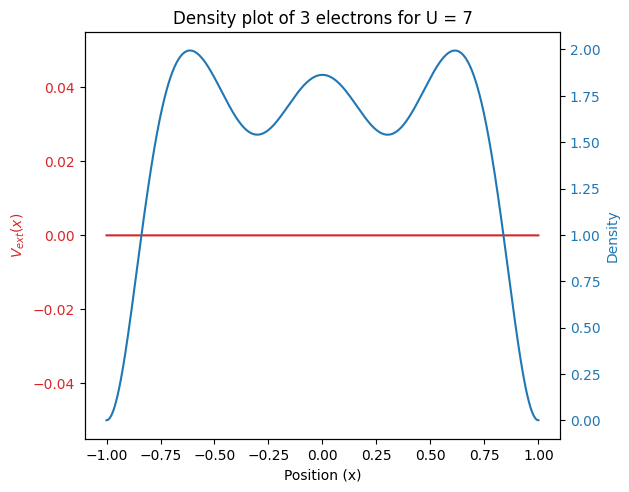

Converged after 55 v cycles
Minimum of potential = -0.11350007268914912
Converged after 55 v cycles
Minimum of potential = -0.11438042787927243
Converged after 55 v cycles
Minimum of potential = -0.1311659320385204
Converged after 55 v cycles
Minimum of potential = -0.13129729433051998
Converged after 55 v cycles
Minimum of potential = -0.1501198370764275
Converged after 55 v cycles
Minimum of potential = -0.15021248425833703
Converged after 55 v cycles
Minimum of potential = -0.15029050584126719
Converged after 55 v cycles
Minimum of potential = -0.1503562643156805
Converged after 55 v cycles
Minimum of potential = -0.17131965417666603
Converged after 55 v cycles
Minimum of potential = -0.1713651712559529
Converged after 55 v cycles
Minimum of potential = -0.17140373486058286
SCF converged after 11 steps for U = 8
Total no. of electrons = 2.9999999999896185


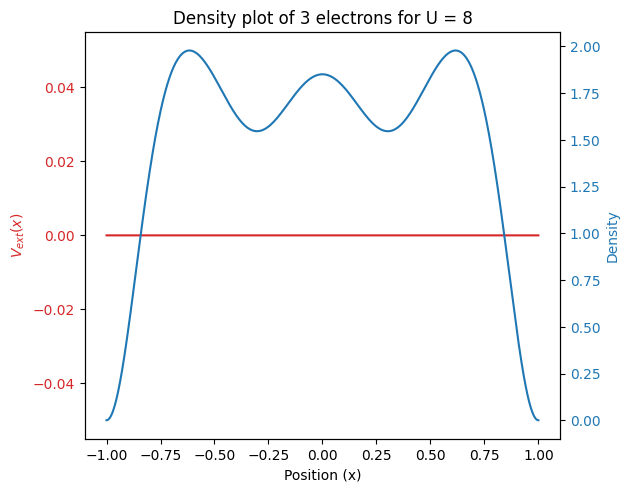

Converged after 55 v cycles
Minimum of potential = -0.17140373486058286
Converged after 55 v cycles
Minimum of potential = -0.17285409100429655
Converged after 55 v cycles
Minimum of potential = -0.19541319554724773
Converged after 55 v cycles
Minimum of potential = -0.19554400569655336
Converged after 55 v cycles
Minimum of potential = -0.21879272429606492
Converged after 55 v cycles
Minimum of potential = -0.21888225655848378
Converged after 55 v cycles
Minimum of potential = -0.21895706925831784
Converged after 55 v cycles
Minimum of potential = -0.21901965632462828
Converged after 55 v cycles
Minimum of potential = -0.21907207789109026
Converged after 56 v cycles
Minimum of potential = -0.24212769366710293
SCF converged after 10 steps for U = 9
Total no. of electrons = 2.999999999991689


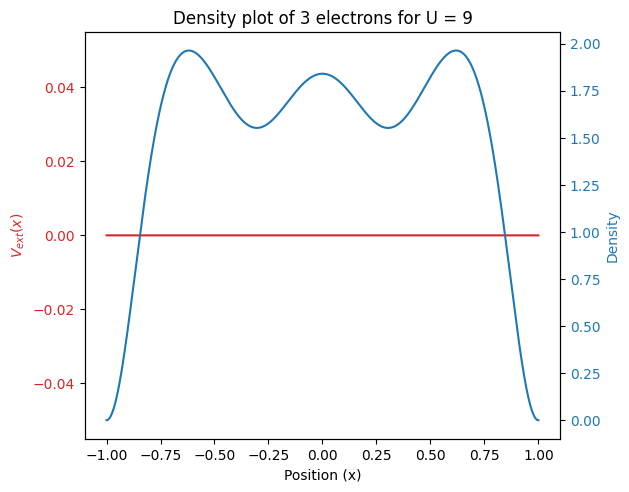

Length of E list : 9
Length of U list : 9


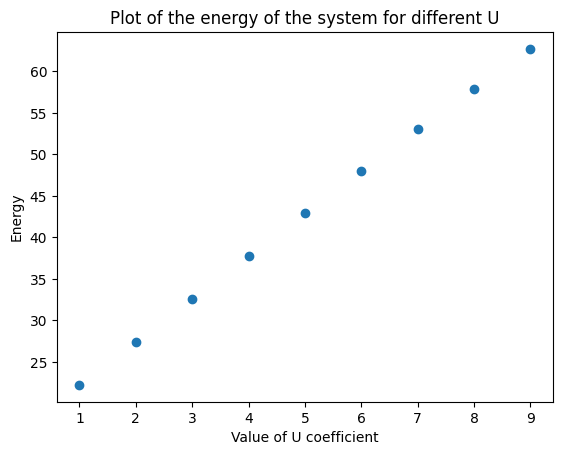

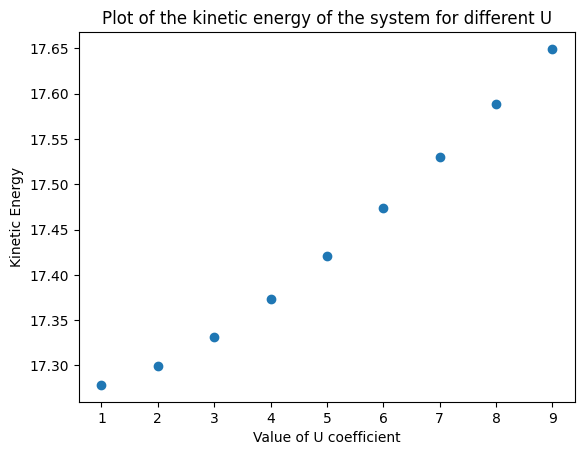

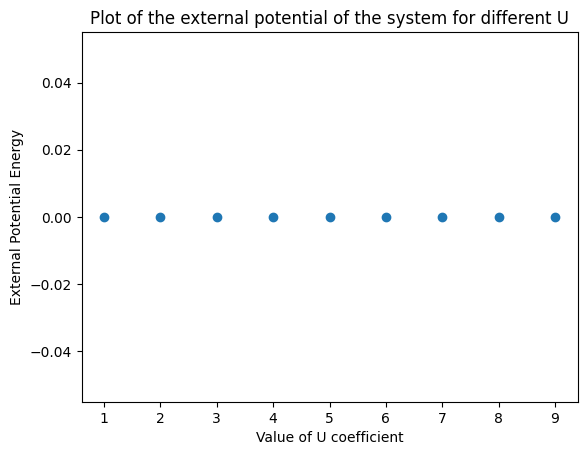

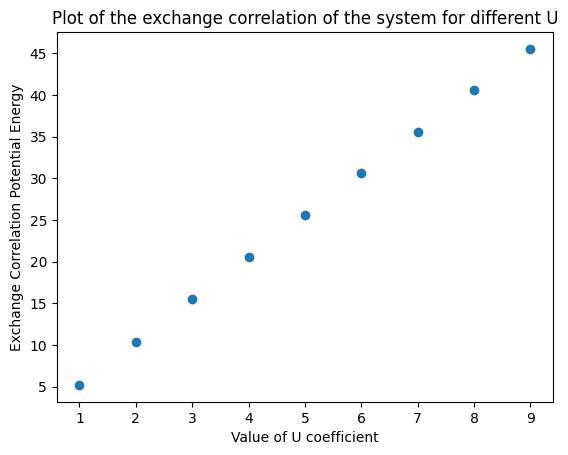

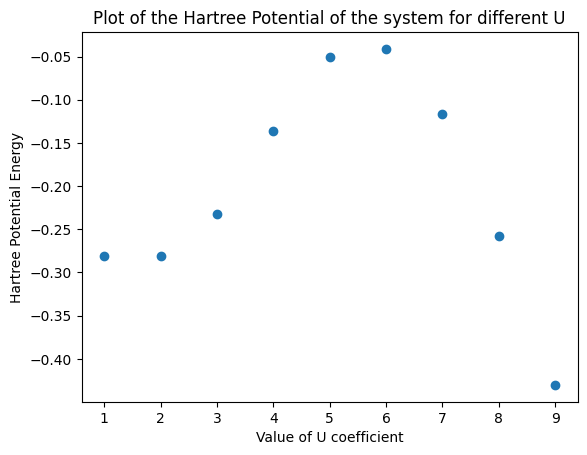

In [12]:
U_plotter([0],[0],[0.1],20,0,0,int(2**11),50,3,np.arange(1,10,1),0.01,0.1)